findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


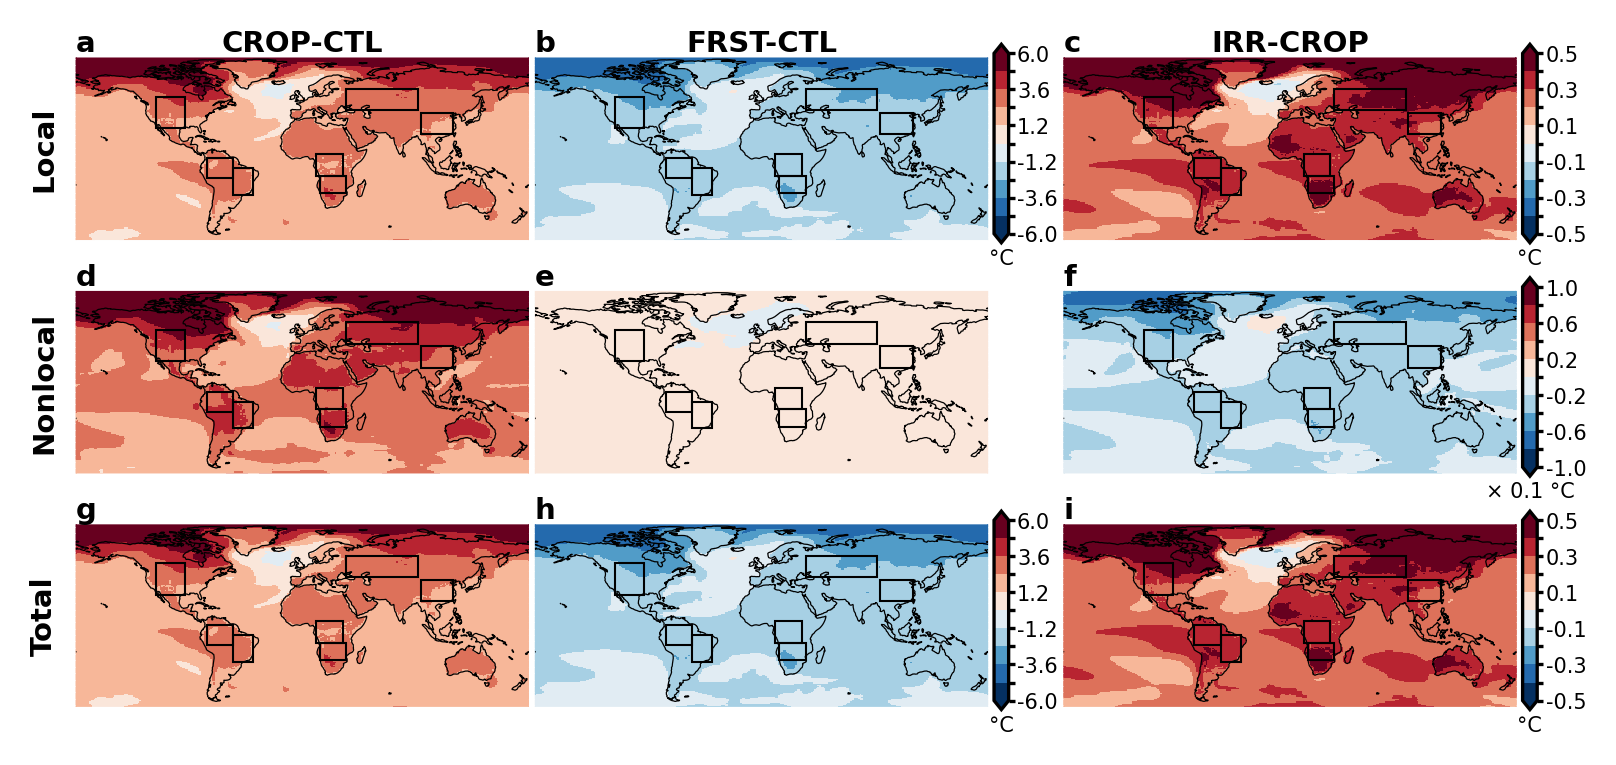

绘图完成，结果已保存到 /scratch/b/b380949/NC-FigS4_BGC_temperature_changes_map_v3.pdf
文件大小: 8.30 MB


In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 7

experiments = ['CROP-CTL', 'FRST-CTL', 'IRR-CROP']
variables = ['tas_local', 'tas_nonlocal', 'tas_total']
variable_labels = ['Local', 'Nonlocal', 'Total']
bounds_a = [-6, -4.8, -3.6, -2.4, -1.2, 0, 1.2, 2.4, 3.6, 4.8, 6]
bounds_b = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
bounds_c = [-0.1, -0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08, 0.1]
bounds_c2 = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
norm_a = BoundaryNorm(bounds_a, ncolors=256)
norm_b = BoundaryNorm(bounds_b, ncolors=256)
norm_c = BoundaryNorm(bounds_c, ncolors=256)
norm_c2 = BoundaryNorm(bounds_c2, ncolors=256)
box_coords = [
    [(244,244,267,267,244), (29,54,54,29,29)],
    [(35,35,92,92,35), (43,60,60,43,43)],
    [(284,284,305,305,284), (-11,5,5,-11,-11)],
    [(11,11,32,32,11), (-9,8,8,-9,-9)],
    [(305,305,321,321,305), (-24,-3,-3,-24,-24)],
    [(14,14,35,35,14), (-23,-9,-9,-23,-23)],
    [(94,94,120,120,94), (24,41,41,24,24)]
]

def create_10level_cmap():
    cmap = cm.get_cmap('RdBu_r')
    colors = [cmap(i)[:3] for i in [0, 28, 56, 85, 113, 143, 170, 198, 226, 255]]
    return LinearSegmentedColormap.from_list('10level_cmap', colors, N=256)

cm_var = 1 / 2.54
fig_width = 16.5 * cm_var
fig_height = 7.7 * cm_var

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

# 3行5列布局：每行两个地图 + colorbar + 第三个地图 + colorbar
gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 0.14, 1, 0.14], wspace=0.02, hspace=0.0)

axes = []
panel_labels = list("abcdefghi")
panel_idx = 0

# 子图安排
for row in range(3):
    row_axes = []
    for col in [0, 1, 3]:  # 只放地图的列
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -60, 85], ccrs.PlateCarree())
        ax.set_frame_on(False)
        fig.text(
            ax.get_position().x0 - 0.0,
            ax.get_position().y1 + 0.0,
            panel_labels[panel_idx],
            fontsize=7, fontweight='bold', ha='left', va='bottom'
        )
        panel_idx += 1
        row_axes.append(ax)
    axes.append(row_axes)

# 标题和行标签
for i, exp in enumerate(experiments):
    if i < 2:
        axes[0][i].set_title(exp, fontsize=7, pad=1.5, fontweight='bold')
    elif i == 2:
        axes[0][2].set_title(exp, fontsize=7, pad=1.5, fontweight='bold')

for i, label in enumerate(variable_labels):
    axes[i][0].text(-0.07, 0.5, label, transform=axes[i][0].transAxes,
                    fontsize=7, ha='center', va='center', rotation=90, fontweight='bold')

# colorbar 轴定义
cbar_axes = {
    (0, 0): fig.add_subplot(gs[0, 2]),
    (0, 2): fig.add_subplot(gs[0, 4]),
    (1, 2): fig.add_subplot(gs[1, 4]),
    (2, 0): fig.add_subplot(gs[2, 2]),
    (2, 2): fig.add_subplot(gs[2, 4]),
}

def draw_colorbar(cax, norm, cmap, bounds, label):
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation='vertical',
        ticks=bounds,
        spacing='proportional',
        extend='both'
    )
    #cb.set_label(label, fontsize=5, labelpad=1)
    cb.ax.tick_params(labelsize=5, direction='out', length=1.5, pad=0.5)

    tick_labels = [f"{b:.1f}" if i % 2 == 0 else "" for i, b in enumerate(bounds)]
    cb.ax.set_yticklabels(tick_labels)  # 如果 colorbar 是 vertical

   # for tick in cb.ax.get_yticklabels():
    #    tick.set_rotation(10)
    
    # 控制 colorbar 的宽度，例如压缩到 40%
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0+0.025, pos.width * 0.23, pos.height * 0.85])
    cb.set_label("")

    # ✅ 手动在 colorbar 下方加上 label
    cax.text(0.5, -0.08, label, transform=cax.transAxes,
             ha='center', va='top', fontsize=5)
    return cb

# 数据读取与绘图
for col, exp in enumerate(experiments):
    if exp == 'IRR-CROP':
        ds = xr.open_dataset(f'/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_RTCRE/final/RTCRE_tas_irri-crop_2models-ensemble_remapbil.nc')
    else:
        ds = xr.open_dataset(f'/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_RTCRE/final/RTCRE_tas_{exp.lower()}_2models-ensemble_remapbil.nc')
    
    for row, var in enumerate(variables):
        # 对应列：0,1,2 → 子图列索引：0,1,2
        ax = axes[row][col if col < 2 else 2]
        data = ds[var].isel(time=0)

        if row in [0, 2] and col in [0, 1]:
            im = ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree(),
                               cmap=create_10level_cmap(), norm=norm_a)
            ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
            if (row, col) in cbar_axes:
                draw_colorbar(cbar_axes[(row, col)], norm_a, create_10level_cmap(), bounds_a, '°C')

        elif row in [0, 2] and col == 2:
            im = ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree(),
                               cmap=create_10level_cmap(), norm=norm_b)
            ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
            if (row, col) in cbar_axes:
                draw_colorbar(cbar_axes[(row, col)], norm_b, create_10level_cmap(), bounds_b, '°C')

        elif row == 1:
            im = ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree(),
                               cmap=create_10level_cmap(), norm=norm_c)
            ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
            if (row, col) in cbar_axes:
                draw_colorbar(cbar_axes[(row, col)], norm_c2, create_10level_cmap(), bounds_c2, '× 0.1 °C')

        for lon, lat in box_coords:
            poly = Polygon(list(zip(lon, lat)), closed=True,
                           transform=ccrs.PlateCarree(),
                           edgecolor='black', facecolor='none',
                           linewidth=0.5)
            ax.add_patch(poly)

#output_path = '/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/NC-FigS4_BGC_temperature_changes_map_v3.jpg'
output_path = '/scratch/b/b380949/NC-FigS4_BGC_temperature_changes_map_v3.pdf'
plt.savefig(output_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

print(f"绘图完成，结果已保存到 {output_path}")
print(f"文件大小: {os.path.getsize(output_path) / (1024 * 1024):.2f} MB")
